In [1]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Parámetros
inputFolder = "1-input"
processFolder = "2-process"
outputFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"
logsFolder = "4-logs"

inputMainFolder = inputFolder + r"\main"
inputMastersFolder = inputFolder + r"\masters"

processMainFolder = processFolder + r"\main"
processSupportFolder = processFolder + r"\support"

dataVisualizationTopLimit = 20

In [3]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def find_nth_right(haystack, needle, n):
    start = haystack.rfind(needle)
    while start >= 0 and n > 1:
        start = haystack.rfind(needle, 0, start-len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( parseNames(parseLineBreaksAndAccents(findTags(tag, color).text)) == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Objetivo Laboral", "Experiencia Laboral", "Educacion", "Informatica", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def getStartAndEndIndex(sectionsIndexes, i):
  return sectionsIndexes[i], getNextSectionIndexValid(sectionsIndexes, i+1)

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          emailAttendeesText = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          emailAttendeesList = emailAttendeesText.split("; ")
          for emailAttendee in emailAttendeesList:
            if emailAttendee not in attendees:
              attendees.append(emailAttendee)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(processSupportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

def readCsv(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def getMissingValues(df):
  percentMissing = df.isnull().sum() * 100 / len(df)
  missingValueDf = pd.DataFrame({'columnName': df.columns, 'percentMissing': percentMissing })
  missingValueDf = missingValueDf.sort_values('percentMissing', ascending=False).reset_index(drop=True)
  display(missingValueDf)

In [4]:
def readAndWritePreprocessedData(preprocessedData, masters):
  ## Decisiones propias para el modelo

  # Transformar la data a dataframe
  df = pd.DataFrame(preprocessedData)

  for i in range(0, len(masters)):
    masters[i] = pd.DataFrame(masters[i])

  # Eliminar los campos que ya no se usarán
  columnsToDelete = [
    "candidatePostulationDate", "jobId", "candidateFullName", "candidateDocumentNumber", "candidateBirthDate", "candidateAddress", "candidateHomeNumber", "candidateCellphoneNumber", "candidateEmail", "workObjetive", "lastWorkDays", "lastWorkDescription", "lastEducationDays", "yearsOfExperience", "yearsOfStudy"
  ]
  # El tema con las ultimas 2 es que puede ser 0 cuando hay o no data de experiencia y educacion, reemplazar el NaN desde el comienzo en el dataframe (understanding)
  df = df.drop(columns=columnsToDelete)

  # Aplicar las equivalencias a los campos: jobProfileName, lastWorkCompany, lastWorkArea, lastWorkName, lastEducationCompany, lastEducationArea, lastEducationName
  equivalences = ["jobProfileName", "lastWorkCompany", "lastWorkName", "lastEducationCompany", "lastEducationName"]

  # Mejorar las equivalencias poco a poco
  for index, equivalence in enumerate(equivalences):
    df = pd.merge(df, masters[index], on=equivalence)
    df[equivalence] = df["equivalence"]
    df = df.drop(columns=["equivalence", "count", "equals"])

  ## Decisiones por la metodología

  # Analisis de valores nulos
  # Reemplazando las cadenas vacias a NaN
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  for column in categoricalColumns:
    df[column] = df[column].replace('',None,regex = True).astype("object")

  # Reemplazando los ceros a NaN
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]
  for column in numericalColumns:
    df[column] = df[column].replace(0,None).astype('float64')

  # Obteniendo el porcentaje de nulos por columna
  getMissingValues(df)
  
  # Tecnica 1: Eliminar la columna si sobrepasa el 30% de nulos
  # Al ninguno superar el 30% de nulos, no se eliminará ninguna columna

  # Tecnica 2: Reemplazar NaN por aleatorizacion de valores no nulos, para variables categoricas
  np.random.seed(0)

  for column in categoricalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else np.random.choice(df[column].dropna().tolist()))

  # Tecnica 3: Reemplazar NaN por el promedio de valores no nulos, para variables numericas
  for column in numericalColumns:
    df[column] = df[column].map(lambda x: x if not pd.isna(x) else round(float(df[column].dropna().mean()), 1) )

  # Obteniendo el nuevo porcentaje de nulos por columna
  getMissingValues(df)

  # Reemplazo de valores atipicos (outliers) (variables numericas)
  # Analizando valores atipicos extremos
  for column in numericalColumns:
    firstQuartil, thirdQuartil = np.percentile(df[column], 25), np.percentile(df[column], 75)
    interQuartilRange = thirdQuartil - firstQuartil
    bottomLimit, topLimit = firstQuartil - 3*interQuartilRange, thirdQuartil + 3*interQuartilRange

    # Reemplazando los valores
    df[column] = df[column].map(lambda x: bottomLimit if x < bottomLimit else x)
    df[column] = df[column].map(lambda x: topLimit if x > topLimit else x)

  # Regresando el dataframe a array de dicts
  preprocessedData = df.to_dict('records')

  writeJson(preprocessedData, os.path.join(outputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(outputFolder, 'result.csv'), 'utf-8')

  writeJson(preprocessedData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return preprocessedData

In [5]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print(df.dtypes)
  print(df.count())

  columns = [columnName for columnName in df.columns]
  categoricalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "object" ]
  numericalColumns = [columnName for columnName, columnType in df.dtypes.to_dict().items() if columnName not in [ "hired" ] and columnType == "float64" ]

  for column in columns:
    if column in numericalColumns:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()
    else:
      topDf = df[column].value_counts().head(dataVisualizationTopLimit)
      print(topDf)
      y_axis = list(reversed(topDf.index))
      x_axis = list(reversed(topDf.values))
      plt.ylabel(column)
      plt.barh(y_axis, x_axis)
      plt.show()

In [6]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  isPreprocessed = False

  # Leyendo la data obtenida en el entendimiento de los datos
  bumeranData = readJson(os.path.join(inputMainFolder, 'result.json'))
  
  # Leyendo archivos maestros
  jobProfileName = readCsv(os.path.join(inputMastersFolder, 'jobProfileName.csv'))
  lastWorkCompany = readCsv(os.path.join(inputMastersFolder, 'lastWorkCompany.csv'))
  lastWorkName = readCsv(os.path.join(inputMastersFolder, 'lastWorkName.csv'))
  lastEducationCompany = readCsv(os.path.join(inputMastersFolder, 'lastEducationCompany.csv'))
  lastEducationName = readCsv(os.path.join(inputMastersFolder, 'lastEducationName.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(outputFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(bumeranData, [jobProfileName, lastWorkCompany, lastWorkName, lastEducationCompany, lastEducationName])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-23 03:23:44.838759
Se inició el procesamiento


,columnName,percentMissing
0,otherSkills,23.044316
1,technicalSkills,11.907514
2,languages,7.514451
3,candidateCivilStatus,6.050096
4,lastWorkCompany,5.520231
5,lastWorkArea,5.443160
6,lastWorkName,5.443160
7,worksNumber,5.443160
8,lastWorkCountry,5.443160
9,salary,4.113680


,columnName,percentMissing
0,jobProfileName,0.0
1,lastEducationCountry,0.0
2,otherSkills,0.0
3,languages,0.0
4,technicalSkills,0.0
5,studiesNumber,0.0
6,lastEducationDegree,0.0
7,lastEducationStatus,0.0
8,lastEducationName,0.0
9,lastEducationArea,0.0


Se terminó el preprocesamiento
jobProfileName                object
candidateResidenceCountry     object
candidateCivilStatus          object
candidateBirthCountry         object
salary                       float64
lastWorkCompany               object
lastWorkCountry               object
lastWorkArea                  object
lastWorkName                  object
worksNumber                  float64
lastEducationCompany          object
lastEducationCountry          object
lastEducationArea             object
lastEducationName             object
lastEducationStatus           object
lastEducationDegree           object
studiesNumber                float64
technicalSkills              float64
languages                    float64
otherSkills                  float64
hired                          int64
dtype: object
jobProfileName               10380
candidateResidenceCountry    10380
candidateCivilStatus         10380
candidateBirthCountry        10380
salary                       10380
las

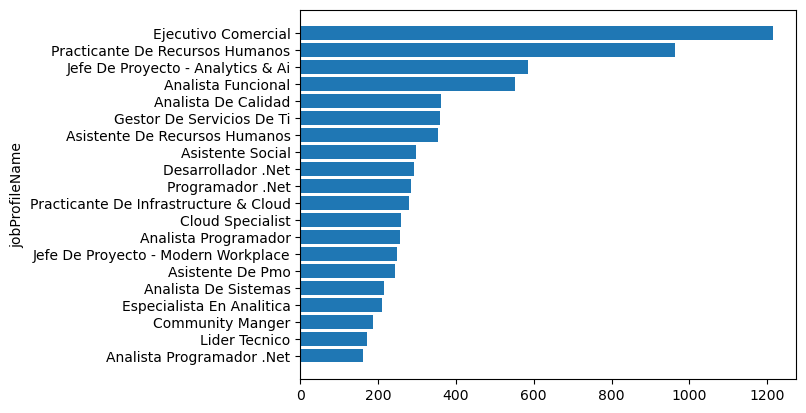

Peru                    10197
Venezuela                 146
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
Espana                      1
Panama                      1
Bolivia                     1
El Salvador                 1
Costa Rica                  1
Francia                     1
Name: candidateResidenceCountry, dtype: int64


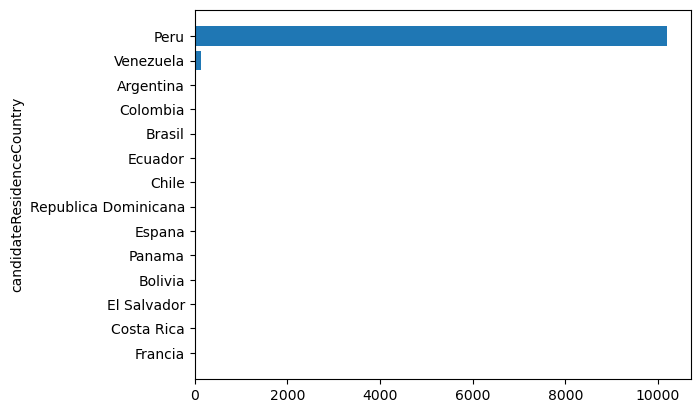

Soltero/A          8462
Casado/A           1616
Divorciado/A        132
Pareja De Hecho     118
Union Libre          49
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


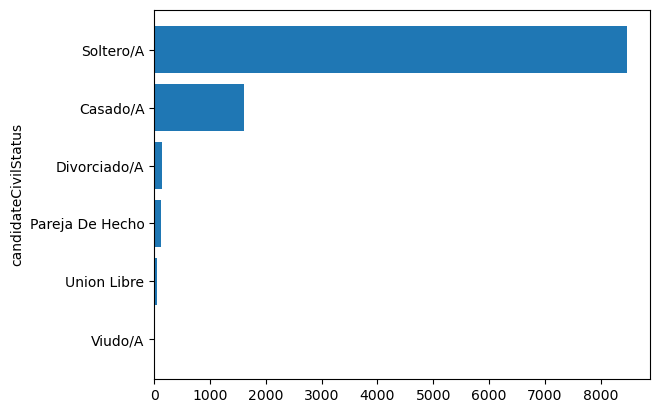

Peru                    10197
Venezuela                 146
Argentina                  11
Colombia                    9
Brasil                      4
Ecuador                     3
Chile                       2
Republica Dominicana        2
Espana                      1
Panama                      1
Bolivia                     1
El Salvador                 1
Costa Rica                  1
Francia                     1
Name: candidateBirthCountry, dtype: int64


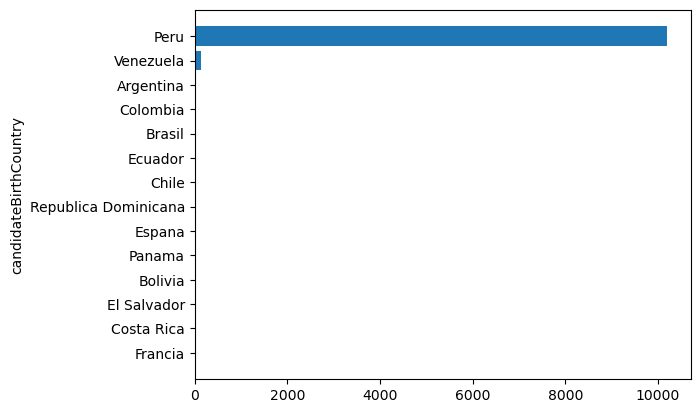

5000.0    628
2500.0    627
2000.0    591
3500.0    571
3000.0    555
4000.0    541
1500.0    475
6000.0    456
4309.4    427
4500.0    418
1200.0    363
1800.0    354
5500.0    315
1025.0    298
6500.0    295
7000.0    291
1000.0    282
930.0     227
8000.0    205
1.0       205
Name: salary, dtype: int64


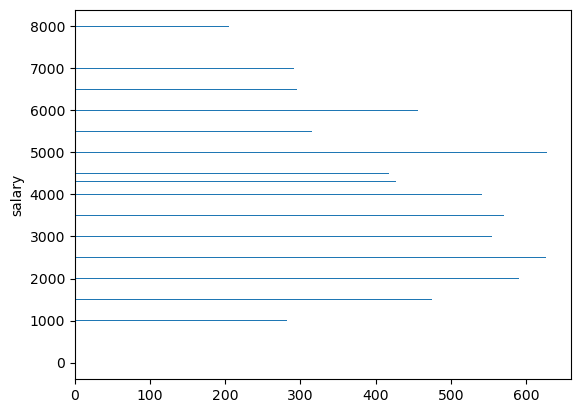

Freelance                                          213
Ntt Data Peru S.A.C.                               185
Canvia S.A.C.                                      173
Global Hitss Peru S.A.C.                           130
Mdp Consulting S.A.C.                              125
Manpower Professional Services S.A.                115
Indra Peru S.A.                                     98
Banco De Credito Del Peru - Bcp                     91
Telefonica Del Peru                                 89
Stefanini It Solutions                              78
Tata Consultancy Services                           60
Corporacion Sapia S.A.                              58
Universidad Peruana De Ciencias Aplicadas (Upc)     44
Tgestiona Sac                                       43
Ferreyros S.A.                                      43
America Movil Peru S.A.C.                           39
Ibm Del Peru S.A.C.                                 38
Oficina Nacional De Procesos Electorales (Onpe)     38
Pontificia

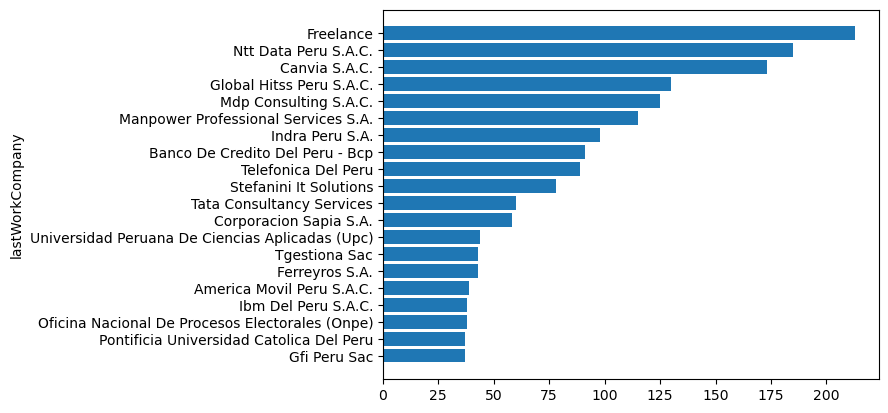

Peru              10192
Estados Unidos       32
Venezuela            31
Espana               25
Colombia             19
Brasil               16
Chile                13
Ecuador               8
Argentina             7
Mexico                4
Albania               3
Costa Rica            3
Reino Unido           3
Panama                2
Francia               2
Italia                2
Paises Bajos          2
Finlandia             2
Australia             2
Noruega               1
Name: lastWorkCountry, dtype: int64


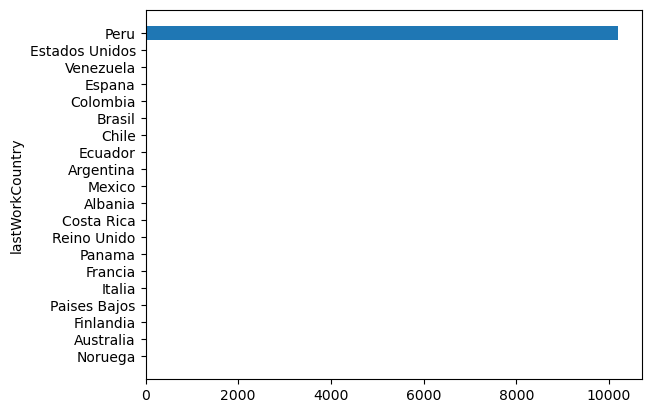

Tecnologia / Sistemas            1131
Tecnologias De La Informacion    1092
Liderazgo De Proyecto             638
Programacion                      625
Comercial                         590
Sistemas                          523
Recursos Humanos                  468
Ventas                            281
Analisis Funcional                280
Administracion                    277
Analisis De Datos                 248
Infraestructura                   229
Soporte Tecnico                   213
Atencion Al Cliente               170
Otras Ingenierias                 162
Seguridad Informatica             162
Desarrollo De Negocios            138
Testing / Qa / Qc                 136
Planeamiento Comercial            124
Telecomunicaciones                124
Name: lastWorkArea, dtype: int64


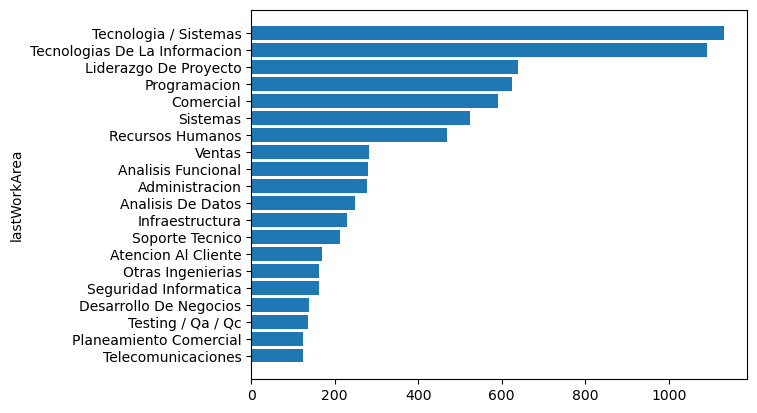

Analista Programador                            571
Analista De Sistemas                            275
Analista Funcional                              196
Jefe De Proyectos                               187
Asistente Administrativo                        109
Analista De Calidad                             105
Trabajadora Social                              105
Ejecutivo Comercial                              96
Asistente De Recursos Humanos                    92
Supervisor De Infraestructura De Redes Cisco     90
Project Manager                                  76
Asesor Comercial                                 73
Lider Tecnico                                    63
Gerente De Proyectos                             62
Soporte Tecnico                                  59
Practicante                                      59
Practicante De Recursos Humanos                  55
Gestor De Proyectos                              53
Analista                                         52
Analista Des

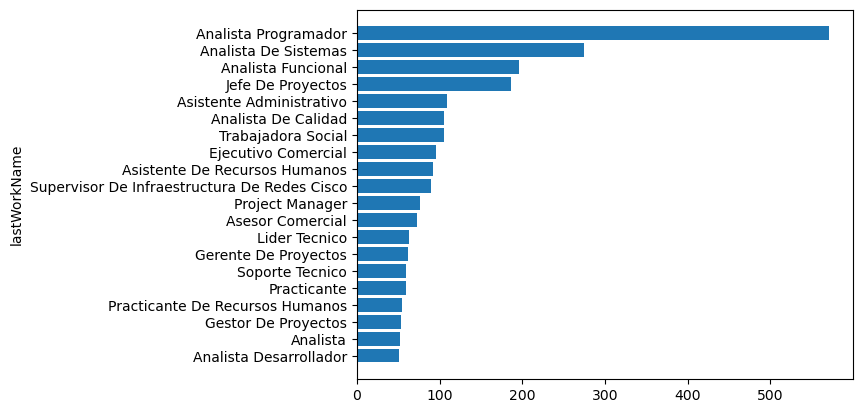

5.0     1315
4.0     1202
6.0     1081
3.0     1035
7.0      955
8.0      746
2.0      742
1.0      665
6.1      565
9.0      540
10.0     413
11.0     282
12.0     245
13.0     154
14.0     123
15.0      95
17.0      61
16.0      47
20.0      46
19.0      37
Name: worksNumber, dtype: int64


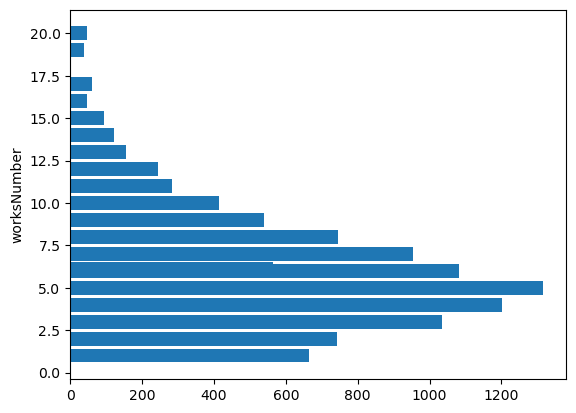

Universidad Peruana De Ciencias Aplicadas    926
Universidad Tecnologica Del Peru             536
Instituto Cibertec                           445
Pontificia Universidad Catolica Del Peru     362
Universidad Privada Del Norte                359
Universidad San Ignacio Del Loyola           333
Universidad Nacional Mayor De San Marcos     330
Universidad Cesar Vallejo                    306
Universidad Esan                             292
Universidad De Lima                          250
Universidad De San Martin De Porres          220
Universidad Nacional De Ingenieria           218
Universidad Ricardo Palma                    193
Universidad Nacional Federico Villarreal     193
Instituto San Ignacio De Loyola              189
Universidad Inca Garcilaso De La Vega        180
Tecsup                                       129
Instituto Superior Tecnologico Idat          117
Universidad Del Pacifico                     112
Universidad Alas Peruanas                    104
Name: lastEducationC

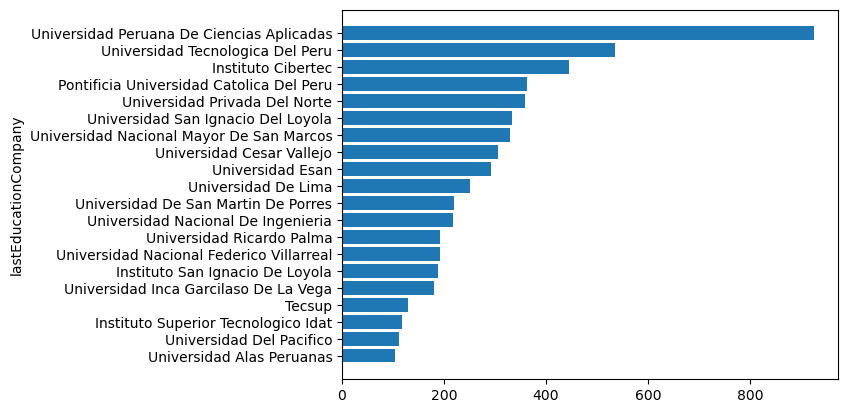

Peru              9759
Espana             199
Venezuela          166
Estados Unidos      78
Mexico              34
Argentina           21
Colombia            19
Brasil              19
Chile               18
Costa Rica          14
Canada               8
Bolivia              6
Australia            6
Ecuador              6
Francia              5
Reino Unido          3
Alemania             3
India                3
Internacional        2
Cuba                 2
Name: lastEducationCountry, dtype: int64


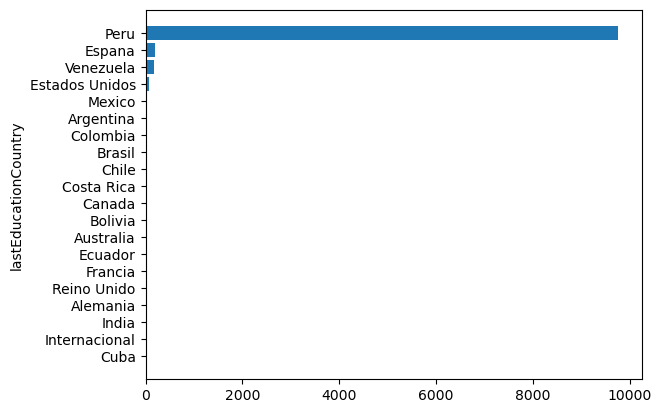

Ing. En Sistemas                  2402
Tecnologias De La Informacion     1279
Adm. De Empresas                  1172
Ing. Informatica                   639
Ing. Industrial                    504
Computacion / Informatica          491
Marketing / Comercializacion       375
Recursos Humanos / Relac. Ind.     364
Otra                               355
Psicologia                         354
Ing. - Otros                       202
Trabajo Social                     152
Analisis De Sistemas               148
Ing. Telecomunicaciones            136
Programacion                       128
Telecomunicaciones                 121
Procesos / Calidad Total           111
Finanzas                            98
Bachiller                           93
Ing. Electronica                    91
Name: lastEducationArea, dtype: int64


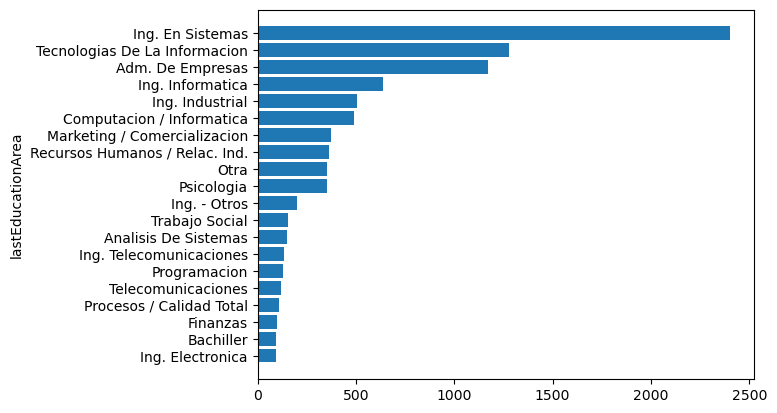

Ingenieria De Sistemas                       1649
Ingenieria Industrial                         340
Psicologia                                    313
Administracion De Empresas                    235
Computacion E Informatica                     182
Mba                                           142
Bachiller En Ingenieria De Sistemas           135
Administracion                                129
Marketing                                     122
Administracion Y Negocios Internacionales      95
Ingles                                         88
Scrum Master                                   77
Gestion De Proyectos                           77
Itil                                           75
Trabajo Social                                 71
Ingenieria Informatica                         63
Ingenieria De Redes Y Comunicaciones           62
Ingenieria De Software                         60
Tecnico En Computacion E Informatica           56
Ingenieria De Computacion Y Sistemas           53


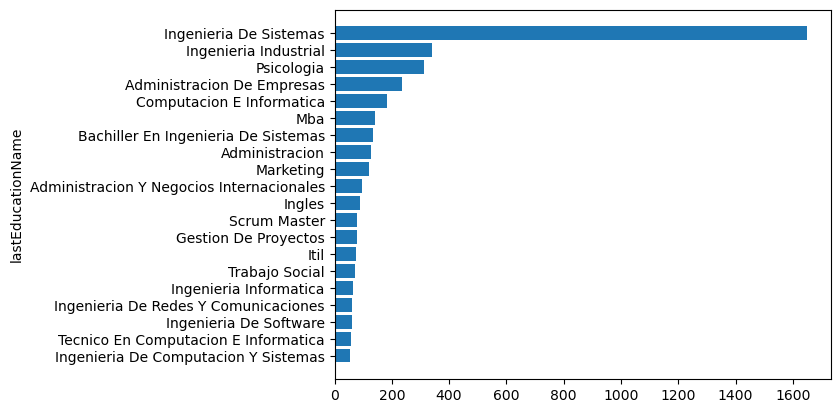

Graduado      6807
En Curso      3397
Abandonado     176
Name: lastEducationStatus, dtype: int64


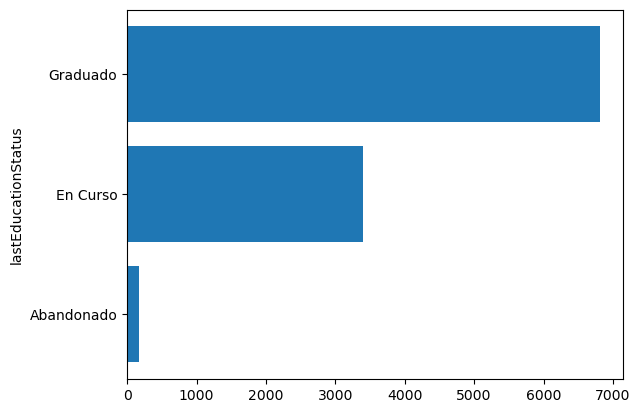

Universitario        5145
Otro                 2336
Posgrado             1220
Terciario/Tecnico    1036
Master                619
Doctorado              13
Secundario             11
Name: lastEducationDegree, dtype: int64


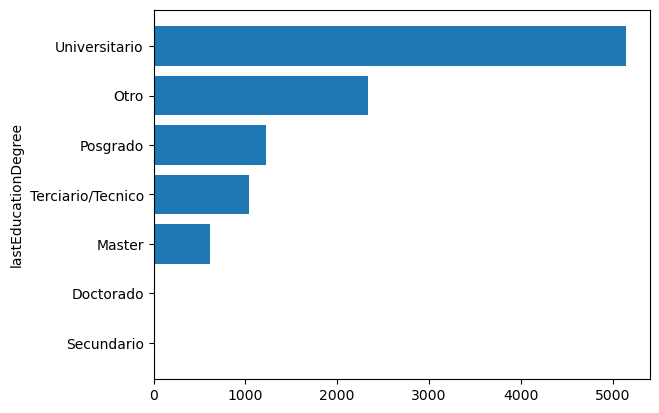

1.0     3857
2.0     2400
3.0     1184
4.0      718
5.0      480
6.0      430
7.0      292
13.0     272
8.0      192
9.0      146
3.2      127
11.0     120
10.0      93
12.0      69
Name: studiesNumber, dtype: int64


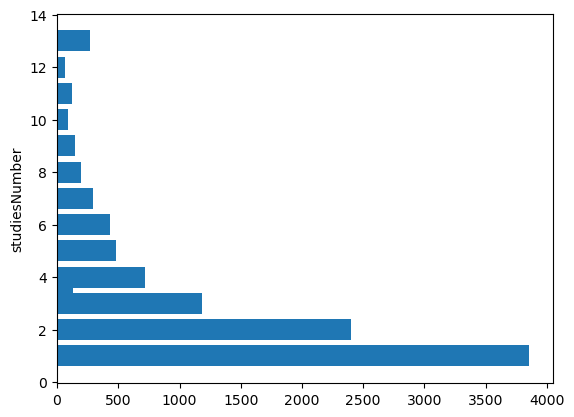

9.4     1236
1.0     1129
3.0      868
2.0      814
4.0      691
5.0      599
6.0      534
7.0      495
9.0      461
8.0      432
11.0     346
10.0     343
35.0     294
12.0     261
13.0     246
16.0     235
14.0     191
15.0     164
17.0     129
18.0     119
Name: technicalSkills, dtype: int64


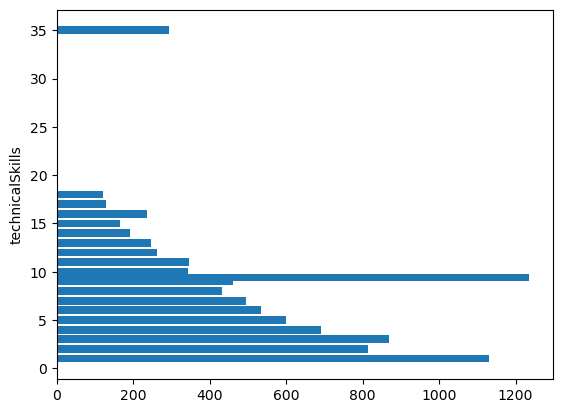

1.0    7227
2.0    2008
1.3     780
2.2     365
Name: languages, dtype: int64


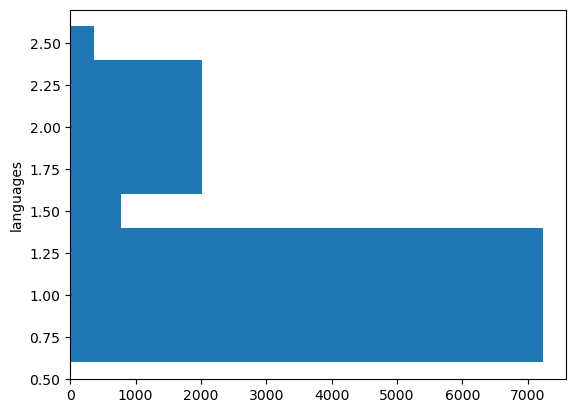

5.4     2392
1.0     1766
2.0     1189
3.0      847
4.0      756
5.0      653
6.0      508
7.0      438
8.0      352
18.0     282
9.0      276
10.0     217
11.0     181
12.0     142
13.0     116
14.0      94
15.0      70
17.0      52
16.0      49
Name: otherSkills, dtype: int64


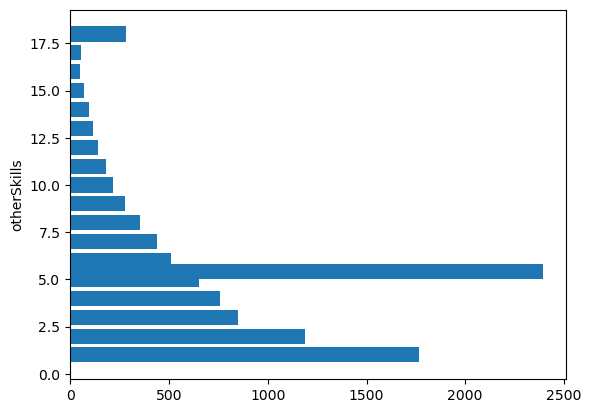

0    9748
1     632
Name: hired, dtype: int64


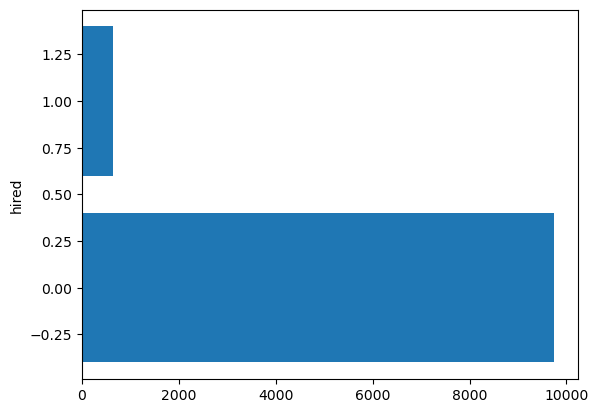

Fin: 2023-05-23 03:23:56.579611
Tiempo: 0:00:11.740852


In [7]:
if __name__ == "__main__":
  main()